## Coral Paleoclimate Practical #1 

This worksheet will go through the basics of coral paleoclimate and basics of python. We will assume no knowledge of python however there are some basics that will help (these would be resources for fututre!); 
- 10 minutes into pandas - https://pandas.pydata.org/docs/user_guide/10min.html#min
- what is xarray - https://tutorial.xarray.dev/overview/xarray-in-45-min.html
- some great xarray examples - https://docs.xarray.dev/en/stable/gallery.html

Some good paleoclimate specific pages; 
- Pyleoclim - https://pyleoclim-util.readthedocs.io/en/latest/

Other free resources; 
- Earth Lab - https://www.earthdatascience.org/courses/use-data-open-source-python/
- ARC Center for Excellence and climate extremes - https://climate-cms.org/index.html

First things first we have to import anything that may be relevant to this tutorial, meaning the important packages

Tips for this, to make sure that cells (each box here is called a cell) are run, you click on each and then either press 'Shift+enter' or the run button at the top.

In [45]:
import pyleoclim as pyleo #this is the paleoclimate python model -- May not use this 
import xarray as xr #xarray is the processing package that helps deal with large datasets (often gridded data)
import pandas as pd #this is the main python package that deals with open source data analysis and manipulation


import sys #this is a module that provides various functions and variables
import numpy as np

from netCDF4 import num2date



import cftime #this is a time related pacakge

# this is all for plotting...
import matplotlib as mpl #mapping and plotting package
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy #this is another mapping package
# from cartopy.util import add_cyclic_point
# from cartopy.mpl.geoaxes import GeoAxes
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import AxesGrid
# from matplotlib.colors import BoundaryNorm
# import matplotlib.colors as colors
# from matplotlib.colors import LinearSegmentedColormap
# import cartopy.feature as cfeature
# import matplotlib.mlab as mlab

import datetime
from datetime import date, datetime, timedelta   # to convert "days since XXX" to date
# import xarray as xr
# import datetime as dt2         # to create a datetime object


#this is all for the stats 

from scipy.signal import find_peaks
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress
import statsmodels.api as sm

from pylr2 import regress2 

We can test this worked by making the notebook do something;

In [3]:
print ('Hello, welcome to this practical!')

# python works on a zero based system (i.e. the numbering starts from 0) and the system works fairly simply
# if you want to test some basic maths for example 

print ('The result of 2+2 is equal to:')
2+2 

Hello, welcome to this practical!
The result of 2+2 is equal to:


4

#### Now we need to import the data that we want to work with. 

In this practical we will be using some previously published coral records, first from the tropical Pacific Island called Palmyra Island (Nurhati et al., 2011). This Palmyra Island coral lies on the edge of the NINO3.4 region, which is a popular measure of the state of El Niño Southern Oscillation. Additionally we will look at a coral record from the Mentawai Islands, in the South East Tropical Indian Ocean (Abram et al., 2020). This region lies within the eastern box of the Dipole Mode Index, which is the index of Indian Ocean Dipole variance.

Both these papers can be found in the github folder!

You will look at following and investigate what this means;
- relationship between coral proxy evidence and sea surface temperature, 
- relationships between the coral proxies and large climate oscillations
- correlations to gridded fields 

## 1. How well do corals in the tropical Pacific reconstruct Sea surface temperature?



The data is in the same folder we are working in so we can just download it straight into this box using a excel read comment.


In [35]:
#we want to upload the coral data here and name it something meaningful
NU11_palmyra = pd.read_excel('palmyra2011.xlsx') 
NU11_palmyra

,Date,d18O,SrCa,SrCa_SST,d18Osw
0,1886.13,-4.79,9.0082,27.843056,0.816194
1,1886.21,-4.89,9.0200,27.708680,0.687975
2,1886.29,-4.81,8.9800,28.164193,0.863632
3,1886.38,-4.84,8.9891,28.060564,0.811870
4,1886.46,-4.85,8.9967,27.974016,0.783695
...,...,...,...,...,...
1342,1997.96,-5.48,8.9167,28.885044,0.345011
1343,1998.04,-5.43,8.9367,28.657287,0.347182
1344,1998.13,-5.49,8.9120,28.938566,0.346251
1345,1998.21,-5.47,8.9000,29.075221,0.394948


The above is called a pandas DataFrame, to make it easier to work with Climate data we want to convert this into a xarray Dataset. This will allow us to compare to the temperature datasets really easily. 

In [50]:
# this code creates an xarrary Dataset, with the Palmyra d18O and SrCa data sorted by Date. 
# It also includes the time information in the above DataFrame
NU11_palmyra_xr = xr.Dataset({'d18O':(['time'],NU11_palmyra.d18O),
                             'SrCa':(['time'],NU11_palmyra.SrCa)},
                     attrs=dict(description="Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m depth"),
                   coords={'Date':NU11_palmyra.Date})

NU11_palmyra_xr

<xarray.Dataset>
Dimensions:  (time: 1347, Date: 1347)
Coordinates:
  * Date     (Date) float64 1.886e+03 1.886e+03 ... 1.998e+03 1.998e+03
Dimensions without coordinates: time
Data variables:
    d18O     (time) float64 -4.79 -4.89 -4.81 -4.84 ... -5.43 -5.49 -5.47 -5.41
    SrCa     (time) float64 9.008 9.02 8.98 8.989 8.997 ... 8.937 8.912 8.9 8.96
Attributes:
    description:  Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m...

One thing to notice here is that the date format is in a decimal (i.e. 1886.13 is equivalent to the middle of February in 1886). In order to more easily manipulate the dates we would like to use something called Datetime. This will allow us to compare the data easily and average the data to annual values etc. 

- see more about datetime here - https://docs.python.org/3/library/datetime.html

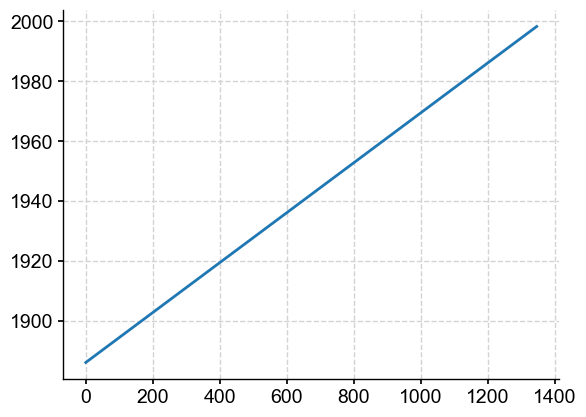

In [36]:
## just going to plot the current decimal date to check that it is linear, there is a way to test this properly 
# however we will just visually check this. 
plt.plot(NU11_palmyra_xr.time) # this plots the time axis on the y-axis, vs the index (which is the position in the data)

In [68]:
# We can create a date_range using the function pd.date_range (https://pandas.pydata.org/docs/reference/api/pandas.date_range.html)
# which will range from the starting date (1886.13) middle of Feb, for the entire length of the xarrary Dataset.
time=(pd.date_range(start='1/2/1886', periods=1347, freq='MS'))
time

DatetimeIndex(['1886-02-01', '1886-03-01', '1886-04-01', '1886-05-01',
               '1886-06-01', '1886-07-01', '1886-08-01', '1886-09-01',
               '1886-10-01', '1886-11-01',
               ...
               '1997-07-01', '1997-08-01', '1997-09-01', '1997-10-01',
               '1997-11-01', '1997-12-01', '1998-01-01', '1998-02-01',
               '1998-03-01', '1998-04-01'],
              dtype='datetime64[ns]', length=1347, freq='MS')

In [69]:
# and finally we can set the date as this range of DatetimeIndex
NU11_palmyra_xr['time']=time

NU11_palmyra_xr

<xarray.Dataset>
Dimensions:  (time: 1347, Date: 1347)
Coordinates:
  * Date     (Date) float64 1.886e+03 1.886e+03 ... 1.998e+03 1.998e+03
  * time     (time) datetime64[ns] 1886-02-01 1886-03-01 ... 1998-04-01
Data variables:
    d18O     (time) float64 -4.79 -4.89 -4.81 -4.84 ... -5.43 -5.49 -5.47 -5.41
    SrCa     (time) float64 9.008 9.02 8.98 8.989 8.997 ... 8.937 8.912 8.9 8.96
Attributes:
    description:  Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m...

Now we want to upload the SST data

I have already segmented the SST for you, and selected it from the OISST dataset (Huang et al., 2021). There are a number of different SST products we could use, however, we will use this one as the original paper says that the in-situ SST in the region best corresponds to the Reynolds SST dataset which is an older version of OISST.




In [70]:
OISST_palmyra = xr.open_dataset('NU11_palmyra_OISST.nc') # this is how we open a netcdf4 file into an xarray dataset 
OISST_palmyra


<xarray.Dataset>
Dimensions:  (time: 200)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 1998-04-01
Data variables:
    sst      (time) float32 ...
Attributes:
    description:  OISSTv2

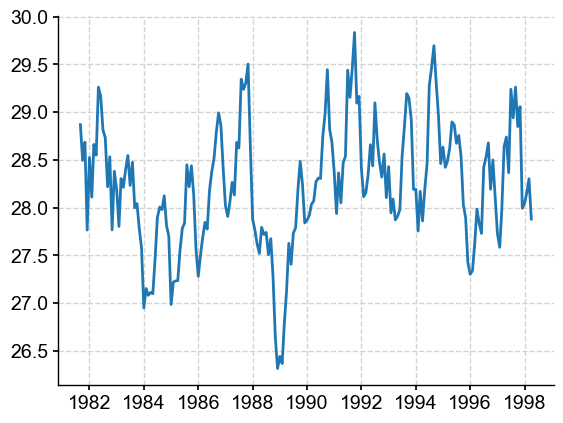

In [71]:
# we can also plot this to see what it looks like 
plt.plot(OISST_palmyra.time, OISST_palmyra.sst)

### Correlations 

Okay now that we have the coral data and the sst in this datasheet we want to look at how well the two datasets relate to each other. We do this by testing the correlation between the two dataset. 

We will look at Sr/Ca of the coral, as this is the proxy related to SST. There are a number of ways to do this, and a number of things to think about (like autocorrelation and lag of the dataset) but we are going to ignore that for the moment. 

To look at the two datasets we need them to be the same length, at the moment the coral spans from 1882-1998 and the sst only covers the instrumental period of the coral (1981-1998). So we have to shorten the coral.


In [74]:
startyr = 1981 # coral_years[0]  # 1980       # start on a specified year
endyr = 1998  # 2000
nyr = endyr-startyr 

t1 = datetime(startyr, 9, 1)     
t2 = datetime(endyr, 4, 1) 
NU11_palmyra_short = NU11_palmyra_xr.sel(time=slice(t1, t2))
NU11_palmyra_short

<xarray.Dataset>
Dimensions:  (time: 200, Date: 1347)
Coordinates:
  * Date     (Date) float64 1.886e+03 1.886e+03 ... 1.998e+03 1.998e+03
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 1998-04-01
Data variables:
    d18O     (time) float64 -5.12 -5.1 -5.11 -5.04 ... -5.43 -5.49 -5.47 -5.41
    SrCa     (time) float64 8.917 8.943 8.957 8.978 ... 8.937 8.912 8.9 8.96
Attributes:
    description:  Palmyra 2011 Nurhati coral, at Palmyra: 5°53'N, 162°5'W, 9m...

In [75]:
#we can just print the length of both to check they are the same, 
# and you can check that the two start at the same time youself
print ('the length of the short coral is - '+ str(len(NU11_palmyra_short.time)))
print ('the length of the SST is - '+ str(len(OISST_palmyra.time)))

the lenght of the short coral is - 200
the lenght of the SST is - 200


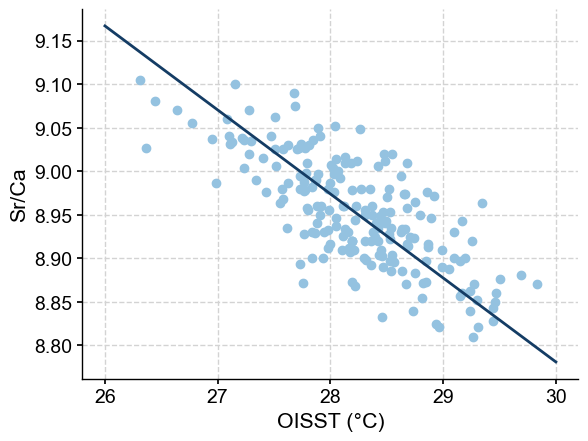

bimonthly ERSST and MAU1 WLS
---------------------------
The slope between ERSST and SrCa -0.09646042143744483
The slope error between ERSST and SrCa 0.004988799066966241
The intercept between ERSST and SrCa 11.674835763336684
The intercept error between ERSST and SrCa 0.1408274803392929
The correlation between ERSST and SrCa -0.7351157152649119


In [88]:
results = regress2(OISST_palmyra.sst.values,NU11_palmyra_short.SrCa.values, _method_type_1="OLS")

x = np.linspace(26,30,100)
y = (results['slope'])*x+results['intercept']

plt.scatter(OISST_palmyra.sst.values,NU11_palmyra_short.SrCa.values,c= '#94c2e0')
plt.plot(x, y, '#143c64', label='y=2x+1')


plt.xlabel('OISST (°C)')
# naming the y axis
plt.ylabel('Sr/Ca')

# plt.savefig('Scatter_OISST_d18O.pdf',dpi=600, bbox_inches='tight')
plt.show()


print ('bimonthly ERSST and MAU1 WLS')
print ('---------------------------')

print ("The slope between ERSST and SrCa " + str(results['slope']))
print ("The slope error between ERSST and SrCa " + str(results['std_slope']))
print ("The intercept between ERSST and SrCa " + str(results['intercept']))
print ("The intercept error between ERSST and SrCa " + str(results['std_intercept']))
print ("The correlation between ERSST and SrCa " + str(results['r']))